In [189]:
! pip install -q kaggle
from google.colab import files
import pandas as pd
import numpy as np
import json
import os
import string
import re

In [2]:
def import_data_from_kaggle(url_dataset, OUTPUT_FOLDER="./dataset/", unzip=True):
  """
  url_dataset String : dataset url from kaggle for example ('https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data')
  OUTPUT_FOLDER String : destination directory for downloaded files ("./dataset/")
  unzip Boolean : if true extract files from zip file 
  """
  # upload APi-key json file download it from your profile from kaggle
  if not os.path.isfile('kaggle.json'):
    print("[+] Upload 'Kaggle.json' api for credentials")
    print(f"[*] You can download it from kaggle profile account 'https://www.kaggle.com/{input('username of kaggle: ')}/account'\n\n")
    files.upload()
  else:
    print("'Kaggle.json' api file already exist")

  os.system("mkdir ~/.kaggle")
  os.system("cp kaggle.json ~/.kaggle/")

  url_list = url_dataset.split('/')

  if unzip:
    os.system("kaggle datasets download -q "+url_list[-2]+"/"+url_list[-1]+" -p "+OUTPUT_FOLDER+url_list[-1]+" --unzip")
  else:
    os.system("kaggle datasets download -q "+url_list[-2]+"/"+url_list[-1]+" -p "+OUTPUT_FOLDER+url_list[-1])

# 1- Download Data to implement Gensim FastText

In [3]:
import_data_from_kaggle("https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset")

[+] Upload 'Kaggle.json' api for credentials
username of kaggle: salim
[*] You can download it from kaggle profile account 'https://www.kaggle.com/salim/account'




Saving kaggle.json to kaggle.json


In [4]:
!rm -r ./dataset/yelp-dataset/Dataset_User_Agreement.pdf
!rm -r ./dataset/yelp-dataset/yelp_academic_dataset_business.json
!rm -r ./dataset/yelp-dataset/yelp_academic_dataset_checkin.json
!rm -r ./dataset/yelp-dataset/yelp_academic_dataset_user.json

In [ ]:
import nltk
nltk.download('all')

In [68]:
# data_list = []
# # TOTAL: 6,990,280 reviews
# batch = 400_000

# with open('./dataset/yelp-dataset/yelp_academic_dataset_review.json') as myfile:
#   for i, line in enumerate(myfile):
#     data_list.append(json.loads(line))
#     if i == batch:
#       break

# yelp_df = pd.DataFrame(data_list)

In [6]:
yelp_df = pd.read_json('./dataset/yelp-dataset/yelp_academic_dataset_tip.json', lines=True)

# Check this dataset and perform Data cleaning

In [7]:
yelp_df.isna().mean(), yelp_df.shape

(user_id             0.0
 business_id         0.0
 text                0.0
 date                0.0
 compliment_count    0.0
 dtype: float64, (908915, 5))

In [190]:
yelp_df = yelp_df[['text']][:150_000]
yelp_df.head(5)

,text
0,Avengers time with the ladies.
1,They have lots of good deserts and tasty cuban...
2,It's open even when you think it isn't
3,Very decent fried chicken
4,Appetizers.. platter special for lunch


## 1-Convert text column into list and subset

In [191]:
list_of_text = yelp_df['text'].to_list()

### 2- text cleaning steps:

### ● Remove all special characters from the text

In [192]:
#defining the function to remove punctuation
def remove_punctuation(text):
  punctuation_free = [i for i in text if i not in string.punctuation]
  punctuation_free = "".join(re.sub("[^A-Za-z']+|\w+\'\w+", ' ', str(line)) for line in punctuation_free)
  return punctuation_free

In [193]:
removed_special_char  = list(map(remove_punctuation, list_of_text))

### ● Remove white extra space from text

In [194]:
removed_extra_space = [re.sub("\s+", ' ', str(line)) for line in removed_special_char]

In [ ]:
removed_extra_space

### ● Remove all single characters from the text

In [195]:
removed_single_char = [line for line in removed_extra_space if not len(line.split(' ')) == 1]

### ● Convert text to lower case

In [196]:
cleaned_text = ""
for line in removed_single_char:
  cleaned_text += line.lower()+" "

### ● Perform Word tokenization

In [197]:
tokenized_text = nltk.word_tokenize(cleaned_text)

In [ ]:
tokenized_text

### ● Remove stop words from the text

In [199]:
from nltk.corpus import stopwords

In [200]:
stopwords_en = stopwords.words('english')

def remove_stopwords(text):
    return [w for w in text if w not in stopwords_en]

In [201]:
text_without_stop = remove_stopwords(tokenized_text)

In [ ]:
text_without_stop

### ● Lemmatization

In [202]:
from nltk.stem import WordNetLemmatizer

In [203]:
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatizer(text):
  lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
  return lemm_text

In [204]:
lemmatized_text = lemmatizer(text_without_stop)

In [ ]:
lemmatized_text

### ● Stemming

In [206]:
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

In [207]:
def stemming(text):
  stem_text = [porter_stemmer.stem(word) for word in text]
  return stem_text

In [208]:
stemmed_text = stemming(lemmatized_text)

In [ ]:
stemmed_text

### ● Remove words length less than 3 from text

In [209]:
final_text = [line for line in stemmed_text if len(line) > 3]

In [210]:
word_tokenizer = nltk.WordPunctTokenizer()

In [ ]:
word_tokens = [word_tokenizer.tokenize(sent) for sent in final_text]
word_tokens

# ● Train fastText word embeddings python

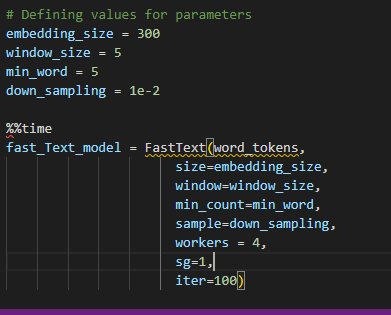

In [212]:
from gensim.models.fasttext import FastText
from gensim.models import Word2Vec

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

In [222]:
EMBEDDING_SIZE = 300
WINDOW_SIZE = 5
MIN_WORD = 5
DOWN_SAMPLING = 1e-3

In [221]:
fast_Text_model = FastText(word_tokens,
                           size=EMBEDDING_SIZE,   #Dimensionality of the word vectors
                           window=WINDOW_SIZE,    #window_size
                           min_count=MIN_WORD,    #The model ignores all words with total frequency lower than this.
                           sample=DOWN_SAMPLING,  #The threshold for configuring which higher-frequency words are randomly down sampled, useful range is (0, 1e-5)
                           workers = 4,           #=> faster training with multicore machines
                           sg=1,                  # Training algorithm: skip-gram if sg=1, otherwise CBOW.
                           iter=120               # Number of iterations (epochs) over the corpus
                           )

In [223]:
if not os.path.exists('model'):
  os.mkdir('model')
# Save fastText model
fast_Text_model.save("./model/model_yelp")
# Load fastText model
fast_Text_model = Word2Vec.load("./model/model_yelp")

### Test Model

In [224]:
# most similar word to input word
fast_Text_model.wv.most_similar('friend', topn=10)

[('boyfriend', 0.6284396648406982),
 ('friendli', 0.5799555778503418),
 ('friendlier', 0.5614292621612549),
 ('friendliest', 0.4994390606880188),
 ('girlfriend', 0.4989783465862274),
 ('unfriendli', 0.3523934483528137),
 ('dogfriendli', 0.32424893975257874),
 ('superfriendli', 0.31963053345680237),
 ('vend', 0.2829885482788086),
 ('offend', 0.28208044171333313)]

In [225]:
# similarity score between two words
fast_Text_model.wv.similarity('dog', 'cat')

0.1052494

In [226]:
# most negative to a word
fast_Text_model.wv.most_similar(negative=["friend"], topn=10)

[('bush', 0.24111774563789368),
 ('lung', 0.22463804483413696),
 ('bella', 0.20624986290931702),
 ('somewher', 0.1945309191942215),
 ('grove', 0.19024920463562012),
 ('stella', 0.18697798252105713),
 ('savori', 0.18668410181999207),
 ('slipper', 0.18304626643657684),
 ('bellevu', 0.1809413582086563),
 ('kung', 0.18079212307929993)]

# FastText word embeddings visualization using T-sne 

In [139]:
import numpy as np

In [143]:
WORD = 'friend'

dim_size = fast_Text_model.wv.vectors.shape[1]
arrays = np.empty((0, dim_size), dtype='f')
word_labels = [WORD]
color_list  = ['red']

arrays = np.append(arrays, fast_Text_model.wv.__getitem__([WORD]), axis=0)
sim_words_list = fast_Text_model.wv.most_similar(WORD, topn=10)

In [144]:
for word_score in sim_words_list:
  wrd_vector = fast_Text_model.wv.__getitem__([word_score[0]])
  word_labels.append(word_score[0])
  color_list.append('green')
  arrays = np.append(arrays, wrd_vector, axis=0)

In [234]:
# PCA and tsne to reduce dimention
pca = PCA(n_components = 0.90, 
          random_state=222).fit_transform(arrays)

tsne = TSNE(n_components=2, 
         random_state=222,
         learning_rate='auto', 
         perplexity=15).fit_transform(pca)

# putting everything in df to plotting
df_plot = pd.DataFrame({'x': [x for x in tsne[:, 0]], #tsne->1th col
                        'y': [y for y in tsne[:, 1]], #tsne->2nd col
                        'words_name': word_labels, 
                        'words_color': color_list
                        })

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Text(0.5, 1.0, 'T-SNE visualization for word (Friend)')

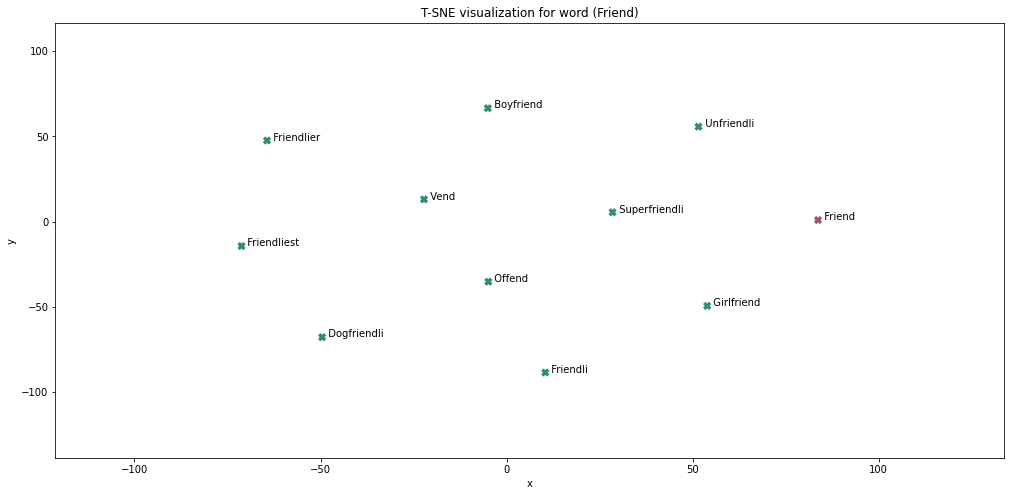

In [235]:
# plot
plt.figure(figsize=(17,8))
plot_dot = sns.regplot(data=df_plot,
                       x="x", 
                       y="y", 
                       fit_reg=False, 
                       marker="X", 
                       scatter_kws={'s': 50, 'facecolors': df_plot['words_color']})

# Adds label on points
for line in range(len(df_plot)):
      plot_dot.text(x= df_plot["x"][line], 
                    y= df_plot['y'][line],
                    s= '  ' + df_plot["words_name"][line].title())


plt.xlim(tsne[:, 0].min()-50, tsne[:, 0].max()+50)
plt.ylim(tsne[:, 1].min()-50, tsne[:, 1].max()+50)

plt.title(f'T-SNE visualization for word ({WORD.title()})')